### Building a model to differentiate between noise, muons and electrons with noise from scratch

In this notebook, we will build a convolutional neural network to classify a signal as electron, muon or noise whe there is noise present in the energy signals. Therefore, we are facing a multiclass classification problem: electron, muon or noise. This is the reason why we will have just one neuron in the output layer with softmax activation.

First we import the data stored in a file called `eVSmuVSn_noisy1.npz` composed of two variables: 'data' for the numpy arrays with energy or noise, and 'labels' where 1 stands for electron signal, 2 for muon signal and 0 for noise.

Actually, we will import the train and test dataset who suffered from a under/oversampling transformation so we have the same number of samples for each class: `eVSmuVSn_trnoisy1.npz` will store the training data and `eVSmuVSn_tenoisy1.npz` will store the testing data.

* [First model: under/oversampled data](#First-model:-under/oversampled-data)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.grid(b=False)
    plt.xlim(-0.5, 2.5)
    plt.ylim(2.5, -0.5)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

Loading and scaling data:

In [3]:
loaded = np.load('/Users/Silvia/Desktop/TFM/e_VS_mu_VS_n/eVSmuVSn_noisytr1.npz')
X_train = loaded['data']
y_train = loaded['labels']

In [4]:
print(X_train.shape, y_train.shape)

(5931, 296, 286) (5931,)


In [6]:
loaded = np.load('/Users/Silvia/Desktop/TFM/e_VS_mu_VS_n/eVSmuVSn_noisyte1.npz')
X_test = loaded['data_test']
y_test = loaded['labels_test']

In [7]:
print(X_test.shape, y_test.shape)

(1715, 296, 286) (1715,)


In [8]:
from sklearn import preprocessing

aux_train = X_train.reshape((X_train.shape[0], X_train.shape[1]* X_train.shape[2]))
aux_test = X_test.reshape((X_test.shape[0], X_test.shape[1]* X_test.shape[2]))

scaler = preprocessing.StandardScaler().fit(aux_train)

X_trainr = scaler.transform(aux_train)

X_testr = scaler.transform(aux_test)

print(X_trainr.shape, X_testr.shape)

(5931, 84656) (1715, 84656)


In [9]:
X_train = X_trainr.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))

print(X_train.shape)

(5931, 296, 286, 1)


In [10]:
X_test = X_testr.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

print(X_test.shape)

(1715, 296, 286, 1)


In [11]:
import keras

Using TensorFlow backend.


In [12]:
from keras import layers, models, optimizers

In [13]:
window_y, window_x = 296,286

### First model: under/oversampled data

In [14]:
model_n1 = models.Sequential()
model_n1.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(window_y, window_x, 1)))
model_n1.add(layers.MaxPooling2D((2,2)))
model_n1.add(layers.Conv2D(64,(3,3), activation='relu'))
model_n1.add(layers.MaxPooling2D((2,2)))
model_n1.add(layers.Conv2D(128,(3,3), activation='relu'))
model_n1.add(layers.MaxPooling2D((2,2)))
model_n1.add(layers.Conv2D(128,(3,3), activation='relu'))
model_n1.add(layers.MaxPooling2D((2,2)))

model_n1.add(layers.Flatten())
model_n1.add(layers.Dense(units= 2050, activation='relu'))
model_n1.add(layers.Dense(units= 512, activation='relu'))
model_n1.add(layers.Dense(units= 3, activation='softmax'))
model_n1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 294, 284, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 147, 142, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 145, 140, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 72, 70, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 70, 68, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 34, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 33, 32, 128)      

In [15]:
model_n1.compile(optimizer=optimizers.RMSprop(lr= 1e-4),loss='categorical_crossentropy', metrics=['acc'])

In [16]:
from keras.utils.np_utils import to_categorical
one_hot_train_labels = to_categorical(y_train)
one_hot_test_labels = to_categorical(y_test)

In [17]:
historyn1 = model_n1.fit(X_train, one_hot_train_labels,  epochs= 20, validation_split = 0.2)

Train on 4744 samples, validate on 1187 samples
Epoch 1/20
4744/4744 [==============================] - 423s 89ms/step - loss: 0.6244 - acc: 0.7492 - val_loss: 1.3786 - val_acc: 0.0893
Epoch 2/20
4744/4744 [==============================] - 385s 81ms/step - loss: 0.4240 - acc: 0.8326 - val_loss: 0.8455 - val_acc: 0.5510
Epoch 3/20
4744/4744 [==============================] - 402s 85ms/step - loss: 0.3180 - acc: 0.8777 - val_loss: 0.8903 - val_acc: 0.5628
Epoch 4/20
4744/4744 [==============================] - 385s 81ms/step - loss: 0.2344 - acc: 0.9191 - val_loss: 0.4220 - val_acc: 0.8644
Epoch 5/20
4744/4744 [==============================] - 381s 80ms/step - loss: 0.1726 - acc: 0.9403 - val_loss: 0.1593 - val_acc: 0.9604
Epoch 6/20
4744/4744 [==============================] - 379s 80ms/step - loss: 0.1351 - acc: 0.9583 - val_loss: 0.1545 - val_acc: 0.9503
Epoch 7/20
4744/4744 [==============================] - 377s 79ms/step - loss: 0.1065 - acc: 0.9677 - val_loss: 0.1554 - val_acc: 

In [18]:
model_n1.save('model_e_mu_or_n_n1.h5')

In [19]:
y_predicted1 = model_n1.predict(X_test)

In [20]:
y_predicted_1 = np.argmax(y_predicted1, axis=1)

In [ ]:
loss, acc = model_n1.evaluate(X_test, y_test)
print('Accuracy with the model: {:5.2f}%'.format(100*acc))

In [21]:
conf1 = confusion_matrix(y_test, y_predicted_1, labels = list([0,1,2]))

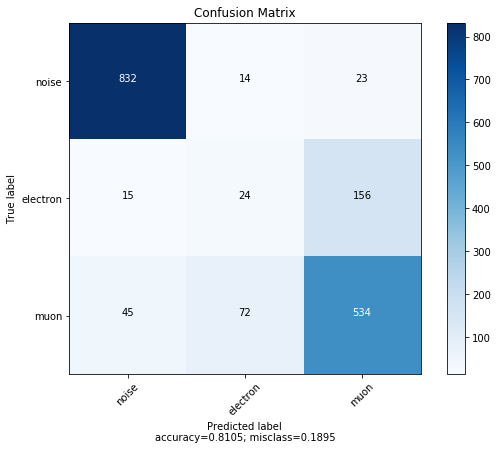

In [22]:
plot_confusion_matrix(cm           = conf1, 
                      normalize    = False,
                      target_names = ['noise', 'electron', 'muon'],
                      title        = "Confusion Matrix")

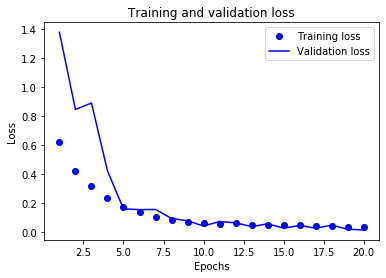

In [23]:
history_n1 = historyn1.history
loss_values_n1 = history_n1['loss']
val_loss_values_n1 = history_n1['val_loss']
epochs_n1 = range(1, len(loss_values_n1) + 1)
plt.plot(epochs_n1, loss_values_n1, 'bo', label='Training loss')
plt.plot(epochs_n1, val_loss_values_n1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import classification_report
target_names = ['noise', 'electron', 'muon']
print(classification_report(y_test, y_predicted_1, target_names=target_names))

              precision    recall  f1-score   support

       noise       0.93      0.96      0.94       869
    electron       0.22      0.12      0.16       195
        muon       0.75      0.82      0.78       651

    accuracy                           0.81      1715
   macro avg       0.63      0.63      0.63      1715
weighted avg       0.78      0.81      0.79      1715



### Second model: one less layer

In [25]:
model_n2 = models.Sequential()
model_n2.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(window_y, window_x, 1)))
model_n2.add(layers.MaxPooling2D((2,2)))
model_n2.add(layers.Conv2D(64,(3,3), activation='relu'))
model_n2.add(layers.MaxPooling2D((2,2)))
model_n2.add(layers.Conv2D(128,(3,3), activation='relu'))
model_n2.add(layers.MaxPooling2D((2,2)))
model_n2.add(layers.Conv2D(128,(3,3), activation='relu'))
model_n2.add(layers.MaxPooling2D((2,2)))

model_n2.add(layers.Flatten())
model_n2.add(layers.Dense(units= 512, activation='relu'))
model_n2.add(layers.Dense(units= 3, activation='softmax'))
model_n2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 294, 284, 32)      320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 147, 142, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 145, 140, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 72, 70, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 70, 68, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 35, 34, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 33, 32, 128)      

In [26]:
model_n2.compile(optimizer=optimizers.RMSprop(lr= 1e-4),loss='categorical_crossentropy', metrics=['acc'])

In [27]:
historyn2 = model_n2.fit(X_train, one_hot_train_labels,  epochs= 15, validation_split = 0.2)

Train on 4744 samples, validate on 1187 samples
Epoch 1/15
4744/4744 [==============================] - 351s 74ms/step - loss: 0.6818 - acc: 0.7220 - val_loss: 1.2764 - val_acc: 0.2190
Epoch 2/15
4744/4744 [==============================] - 318s 67ms/step - loss: 0.4561 - acc: 0.8202 - val_loss: 1.0620 - val_acc: 0.4591
Epoch 3/15
4744/4744 [==============================] - 318s 67ms/step - loss: 0.3559 - acc: 0.8693 - val_loss: 0.6323 - val_acc: 0.7355
Epoch 4/15
4744/4744 [==============================] - 314s 66ms/step - loss: 0.2834 - acc: 0.8995 - val_loss: 0.5033 - val_acc: 0.8121
Epoch 5/15
4744/4744 [==============================] - 317s 67ms/step - loss: 0.2279 - acc: 0.9247 - val_loss: 0.7644 - val_acc: 0.6251
Epoch 6/15
4744/4744 [==============================] - 314s 66ms/step - loss: 0.1906 - acc: 0.9368 - val_loss: 0.2397 - val_acc: 0.9385
Epoch 7/15
4744/4744 [==============================] - 318s 67ms/step - loss: 0.1545 - acc: 0.9500 - val_loss: 0.3827 - val_acc: 

In [28]:
model_n2.save('model_e_mu_or_n_n2.h5')

In [33]:
loss, acc = model_n2.evaluate(X_test, one_hot_test_labels)
print('Accuracy with the model: {:5.2f}%'.format(100*acc))

1715/1715 [==============================] - 30s 17ms/step
Accuracy with the model: 82.27%


In [29]:
y_predicted2 = model_n2.predict(X_test)
y_predicted_2 = np.argmax(y_predicted2, axis=1)

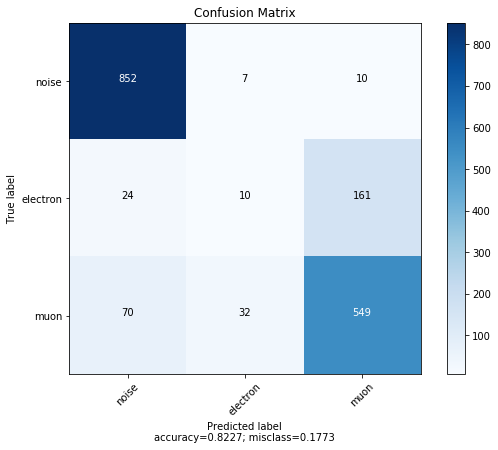

In [30]:
conf2 = confusion_matrix(y_test, y_predicted_2, labels = list([0,1,2]))
plot_confusion_matrix(cm           = conf2, 
                      normalize    = False,
                      target_names = ['noise', 'electron', 'muon'],
                      title        = "Confusion Matrix")

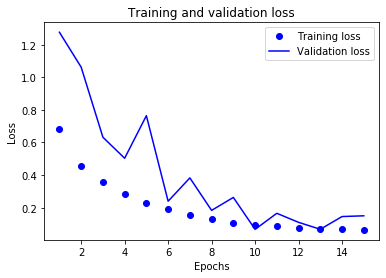

In [34]:
history_n2 = historyn2.history
loss_values_n2 = history_n2['loss']
val_loss_values_n2 = history_n2['val_loss']
epochs_n2 = range(1, len(loss_values_n2) + 1)
plt.plot(epochs_n2, loss_values_n2, 'bo', label='Training loss')
plt.plot(epochs_n2, val_loss_values_n2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
target_names = ['noise', 'electron', 'muon']
print(classification_report(y_test, y_predicted_2, target_names=target_names))

              precision    recall  f1-score   support

       noise       0.90      0.98      0.94       869
    electron       0.20      0.05      0.08       195
        muon       0.76      0.84      0.80       651

    accuracy                           0.82      1715
   macro avg       0.62      0.63      0.61      1715
weighted avg       0.77      0.82      0.79      1715

